# Import required libraries

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.cm as cm
from matplotlib import pyplot as plt 
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense

# packages for learning from crowds
from crowd_layer.crowd_layers import CrowdsClassification, MaskedMultiCrossEntropy
from crowd_layer.crowd_aggregators import CrowdsCategoricalAggregator

# prevent tensorflow from allocating the entire GPU memory at once
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)

Using TensorFlow backend.


# Configuration parameters

In [2]:
NUM_RUNS = 30
DATA_PATH = "/Users/yangyajing/Documents/noisy_dataset/LabelMe/prepared/"
N_CLASSES = 8
BATCH_SIZE = 64
N_EPOCHS = 50

# Load data

In [3]:
def load_data(filename):
    f = open(filename, 'rb')
    data = np.load(f)
    f.close()
    return data

In [4]:
print("\nLoading train data...")

# images processed by VGG16
data_train_vgg16 = load_data(DATA_PATH+"data_train_vgg16.npy")
print(data_train_vgg16.shape)

# ground truth labels
labels_train = load_data(DATA_PATH+"labels_train.npy")
print(labels_train.shape)

# labels obtained from majority voting
labels_train_mv = load_data(DATA_PATH+"labels_train_mv.npy")
print(labels_train_mv.shape)

# labels obtained by using the approach by Dawid and Skene
labels_train_ds = load_data(DATA_PATH+"labels_train_DS.npy")
print(labels_train_ds.shape)

# data from Amazon Mechanical Turk
print("\nLoading AMT data...")
answers = load_data(DATA_PATH+"answers.npy")
print(answers.shape)
N_ANNOT = answers.shape[1]
print("\nN_CLASSES:", N_CLASSES)
print("N_ANNOT:", N_ANNOT)

# load test data
print("\nLoading test data...")

# images processed by VGG16
data_test_vgg16 = load_data(DATA_PATH+"data_test_vgg16.npy")
print(data_test_vgg16.shape)

# test labels
labels_test = load_data(DATA_PATH+"labels_test.npy")
print(labels_test.shape)


Loading train data...
(10000, 4, 4, 512)
(10000,)
(10000,)
(10000,)

Loading AMT data...
(10000, 59)

N_CLASSES: 8
N_ANNOT: 59

Loading test data...
(1188, 4, 4, 512)
(1188,)


# Convert data to one-hot encoding

In [5]:
def one_hot(target, n_classes):
    targets = np.array([target]).reshape(-1)
    one_hot_targets = np.eye(n_classes)[targets]
    return one_hot_targets

In [6]:
print("\nConverting to one-hot encoding...")
labels_train_bin = one_hot(labels_train, N_CLASSES)
print(labels_train_bin.shape)
labels_train_mv_bin = one_hot(labels_train_mv, N_CLASSES)
print(labels_train_mv_bin.shape)
labels_train_ds_bin = one_hot(labels_train_ds, N_CLASSES)
print(labels_train_ds_bin.shape)
labels_test_bin = one_hot(labels_test, N_CLASSES)
print(labels_test_bin.shape)

answers_bin_missings = []
for i in range(len(answers)):
    row = []
    for r in range(N_ANNOT):
        if answers[i,r] == -1:
            row.append(-1 * np.ones(N_CLASSES))
        else:
            row.append(one_hot(answers[i,r], N_CLASSES)[0,:])
    answers_bin_missings.append(row)
answers_bin_missings = np.array(answers_bin_missings).swapaxes(1,2)
answers_bin_missings.shape


Converting to one-hot encoding...
(10000, 8)
(10000, 8)
(10000, 8)
(1188, 8)


(10000, 8, 59)

# Define the base deep learning model

Here we shall use features representation produced by the VGG16 network as the input. Our base model is then simply composed by one densely-connected layer with 128 hidden units and an output dense layer. We use 50% dropout between the two dense layers.

In [7]:
def build_base_model():
    base_model = Sequential()
    base_model.add(Flatten(input_shape=data_train_vgg16.shape[1:]))
    base_model.add(Dense(128, activation='relu'))
    base_model.add(Dropout(0.5))
    base_model.add(Dense(N_CLASSES))
    base_model.add(Activation("softmax"))
    base_model.compile(optimizer='adam', loss='categorical_crossentropy')

    return base_model

# Auxiliary function for evaluating the models

In [8]:
def eval_model(model, test_data, test_labels):
    # testset accuracy
    preds_test = model.predict(test_data)
    preds_test_num = np.argmax(preds_test, axis=1)
    accuracy_test = 1.0*np.sum(preds_test_num == test_labels) / len(test_labels)

    return accuracy_test

# Train the model on the true labels (ground truth) and evaluate on testset

In [16]:
model = build_base_model()
model.fit(data_train_vgg16, labels_train_bin, epochs=N_EPOCHS, shuffle=True, batch_size=BATCH_SIZE, verbose=2)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Epoch 1/50
2s - loss: 0.5457
Epoch 2/50
1s - loss: 0.2074
Epoch 3/50
1s - loss: 0.1446
Epoch 4/50
1s - loss: 0.0994
Epoch 5/50
2s - loss: 0.0707
Epoch 6/50
2s - loss: 0.0543
Epoch 7/50
1s - loss: 0.0446
Epoch 8/50
2s - loss: 0.0434
Epoch 9/50
3s - loss: 0.0382
Epoch 10/50
2s - loss: 0.0383
Epoch 11/50
2s - loss: 0.0321
Epoch 12/50
2s - loss: 0.0348
Epoch 13/50
2s - loss: 0.0539
Epoch 14/50
2s - loss: 0.0381
Epoch 15/50
1s - loss: 0.0301
Epoch 16/50
1s - loss: 0.0303
Epoch 17/50
1s - loss: 0.0272
Epoch 18/50
1s - loss: 0.0321
Epoch 19/50
1s - loss: 0.0316
Epoch 20/50
1s - loss: 0.0300
Epoch 21/50
1s - loss: 0.0275
Epoch 22/50
1s - loss: 0.0193
Epoch 23/50
1s - loss: 0.0296
Epoch 24/50
1s - loss: 0.0321
Epoch 25/50
1s - loss: 0.0324
Epoch 26/50
1s - loss: 0.0245
Epoch 27/5

In [10]:
accuracy_test = eval_model(model, data_test_vgg16, labels_test)
print "Accuracy: Test: %.3f" % (accuracy_test,) 

Accuracy: Test: 0.912


# Train the model on the output of majority voting and evaluate on testset

In [17]:
model = build_base_model()
model.fit(data_train_vgg16, labels_train_mv_bin, epochs=N_EPOCHS, shuffle=True, batch_size=BATCH_SIZE, verbose=2)

Epoch 1/50
2s - loss: 0.9171
Epoch 2/50
2s - loss: 0.5398
Epoch 3/50
2s - loss: 0.3974
Epoch 4/50
2s - loss: 0.3053
Epoch 5/50
2s - loss: 0.2459
Epoch 6/50
2s - loss: 0.1892
Epoch 7/50
2s - loss: 0.1580
Epoch 8/50
2s - loss: 0.1421
Epoch 9/50
2s - loss: 0.1291
Epoch 10/50
2s - loss: 0.1125
Epoch 11/50
2s - loss: 0.1062
Epoch 12/50
2s - loss: 0.0980
Epoch 13/50
1s - loss: 0.0879
Epoch 14/50
1s - loss: 0.0839
Epoch 15/50
1s - loss: 0.0748
Epoch 16/50
1s - loss: 0.0900
Epoch 17/50
1s - loss: 0.0791
Epoch 18/50
1s - loss: 0.0760
Epoch 19/50
1s - loss: 0.0677
Epoch 20/50
1s - loss: 0.0665
Epoch 21/50
2s - loss: 0.0638
Epoch 22/50
2s - loss: 0.0615
Epoch 23/50
2s - loss: 0.0833
Epoch 24/50
2s - loss: 0.0940
Epoch 25/50
1s - loss: 0.0862
Epoch 26/50
1s - loss: 0.0705
Epoch 27/50
1s - loss: 0.0700
Epoch 28/50
2s - loss: 0.0968
Epoch 29/50
2s - loss: 0.0768
Epoch 30/50
2s - loss: 0.0679
Epoch 31/50
2s - loss: 0.0699
Epoch 32/50
2s - loss: 0.0669
Epoch 33/50
2s - loss: 0.0742
Epoch 34/50
2s - lo

In [19]:
accuracy_test = eval_model(model, data_test_vgg16, labels_test)
print("Accuracy: Test: %.3f" % (accuracy_test,)) 

Accuracy: Test: 0.785


# Train the model on the output of Dawid & Skene [1] and evaluate on testset

[1] Dawid, A.P. and Skene, A.M., 1979. Maximum likelihood estimation of observer error-rates using the EM algorithm. Applied statistics, pp.20-28.

In [20]:
model = build_base_model()
model.fit(data_train_vgg16, labels_train_ds_bin, epochs=N_EPOCHS, shuffle=True, batch_size=BATCH_SIZE, verbose=2)

Epoch 1/50
2s - loss: 0.8759
Epoch 2/50
1s - loss: 0.5004
Epoch 3/50
1s - loss: 0.3460
Epoch 4/50
1s - loss: 0.2597
Epoch 5/50
1s - loss: 0.2071
Epoch 6/50
1s - loss: 0.1654
Epoch 7/50
1s - loss: 0.1487
Epoch 8/50
1s - loss: 0.1245
Epoch 9/50
1s - loss: 0.1215
Epoch 10/50
1s - loss: 0.1050
Epoch 11/50
1s - loss: 0.0912
Epoch 12/50
2s - loss: 0.0870
Epoch 13/50
2s - loss: 0.0780
Epoch 14/50
2s - loss: 0.0760
Epoch 15/50
1s - loss: 0.0814
Epoch 16/50
1s - loss: 0.0671
Epoch 17/50
1s - loss: 0.0709
Epoch 18/50
1s - loss: 0.0806
Epoch 19/50
1s - loss: 0.0660
Epoch 20/50
1s - loss: 0.0583
Epoch 21/50
1s - loss: 0.0532
Epoch 22/50
1s - loss: 0.0532
Epoch 23/50
1s - loss: 0.0666
Epoch 24/50
2s - loss: 0.0595
Epoch 25/50
2s - loss: 0.0631
Epoch 26/50
1s - loss: 0.0480
Epoch 27/50
1s - loss: 0.0588
Epoch 28/50
1s - loss: 0.0703
Epoch 29/50
1s - loss: 0.0613
Epoch 30/50
1s - loss: 0.0577
Epoch 31/50
1s - loss: 0.0606
Epoch 32/50
1s - loss: 0.0523
Epoch 33/50
1s - loss: 0.0389
Epoch 34/50
1s - lo

In [21]:
accuracy_test = eval_model(model, data_test_vgg16, labels_test)
print("Accuracy: Test: %.3f" % (accuracy_test,)) 

Accuracy: Test: 0.813


# Train the model using EM approach and evaluate on testset

The CrowdsCategoricalAggregator class acts as a wrapper for the base model that computed the EM steps.

In [24]:
model = build_base_model()
crowds_agg = CrowdsCategoricalAggregator(model, data_train_vgg16, answers, batch_size=BATCH_SIZE)
for epoch in range(N_EPOCHS):
    print("Epoch:", epoch+1)
    
    # E-step
    ground_truth_est = crowds_agg.e_step()
    print("Adjusted ground truth accuracy:", 1.0*np.sum(np.argmax(ground_truth_est, axis=1) == labels_train) / len(labels_train))
    
    # M-step
    model, pi = crowds_agg.m_step()

Epoch: 1
E-step
Adjusted ground truth accuracy: 0.769
M-step
loss: 0.908360270690918
Epoch: 2
E-step
Adjusted ground truth accuracy: 0.8223
M-step
loss: 0.09061147568225861
Epoch: 3
E-step
Adjusted ground truth accuracy: 0.8335
M-step
loss: 0.08477370660305023
Epoch: 4
E-step
Adjusted ground truth accuracy: 0.8456
M-step
loss: 0.07502520937919617
Epoch: 5
E-step
Adjusted ground truth accuracy: 0.8512
M-step
loss: 0.06299123305082321
Epoch: 6
E-step
Adjusted ground truth accuracy: 0.8568
M-step
loss: 0.0570142375767231
Epoch: 7
E-step
Adjusted ground truth accuracy: 0.8595
M-step
loss: 0.05246899654865265
Epoch: 8
E-step
Adjusted ground truth accuracy: 0.8554
M-step
loss: 0.05003881833553314
Epoch: 9
E-step
Adjusted ground truth accuracy: 0.863
M-step
loss: 0.04662610713839531
Epoch: 10
E-step
Adjusted ground truth accuracy: 0.8667
M-step
loss: 0.03936486002206802
Epoch: 11
E-step
Adjusted ground truth accuracy: 0.8612
M-step
loss: 0.04093037679195404
Epoch: 12
E-step
Adjusted ground tr

In [25]:
accuracy_test = eval_model(model, data_test_vgg16, labels_test)
print("Accuracy: Test: %.3f" % (accuracy_test,)) 

Accuracy: Test: 0.816


# Train the model using proposed DL-MW approach and evaluate on testset

We start by adding a new layer (CrowdsClassification) on top of our neural network. We then require a special loss (MaskedMultiCrossEntropy) to handle the missing labels from some of the annotators (encoded as "-1").

Notice how the training is faster then the EM approach.

In [9]:
model = build_base_model()

# add crowds layer on top of the base model
model.add(CrowdsClassification(N_CLASSES, N_ANNOT, conn_type="VW"))

# instantiate specialized masked loss to handle missing answers
loss = MaskedMultiCrossEntropy().loss

# compile model with masked loss and train
model.compile(optimizer='adam', loss=loss)
model.fit(data_train_vgg16, answers_bin_missings, epochs=N_EPOCHS, shuffle=True, batch_size=BATCH_SIZE, verbose=2)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

Epoch 1/50
6s - loss: 0.0722
Epoch 2/50
2s - loss: 0.0647
Epoch 3/50
2s - loss: 0.0614
Epoch 4/50
3s - loss: 0.0587
Epoch 5/50
2s - loss: 0.0564
Epoch 6/50
3s - loss: 0.0543
Epoch 7/50
2s - loss: 0.0522
Epoch 8/50
2s - loss: 0.0505
Epoch 9/50
2s - loss: 0.0489
Epoch 10/50
3s - loss: 0.0474
Epoch 11/50
3s - loss: 0.0458
Epoch 12/50
2s - loss: 0.0446
Epoch 13/50
3s - loss: 0.0435
Epoch 14/50
2s - loss: 0.0425
Epoch 15/50
3s - loss: 0.0414
Epoch 16/50
3s - loss: 0.0404
Epoch 17/50
3s - loss: 0.0394
Epoch 18/50
2s - loss: 0.0385
Epoch 19/50
2s - loss: 0.0374
Epoch 20/50
2s - loss: 0.036

Before evaluating our model, we need to remove the crowds layer used during training in order to expose the aggregation (bottleneck) layer

In [49]:
# save weights from crowds layer for later
weights = model.layers[5].get_weights()

# remove crowds layer before making predictions
model.pop() 
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

accuracy_test = eval_model(model, data_test_vgg16, labels_test)
print("Accuracy: Test: %.3f" % (accuracy_test,)) 

Accuracy: Test: 0.829


# Train the model using MW with softmax noise adaption layer approach and evaluate on testset

In [ ]:
baseline_confusion = []
for a in range(N_ANNOT):
    # get data, label, answer(noisy label) that the annotator labeled.
    data_train_vgg16_a = data_train_vgg16[answers[:,a]>0]
    print(data_train_vgg16_a.shape)
    answers_a = answers[answers[:,a]>0,a]
    answers_a_mv_bin = one_hot(answers_a, N_CLASSES)
    print(answers_a_mv_bin.shape)
    model_a = build_base_model()
    model_a.fit(data_train_vgg16_a, answers_a_mv_bin, epochs=N_EPOCHS, shuffle=True, batch_size=20, verbose=0)
    baseline_predict_a = model.predict(data_train_vgg16_a,batch_size=BATCH_SIZE)
    baseline_predict_a = np.argmax(baseline_predict_a, axis=-1)
    baseline_confusion_a = np.zeros((N_CLASSES, N_CLASSES))
    for n, p in zip(answers_a, baseline_predict_a):
        baseline_confusion_a[p, n] += 1.
    print('baseline_confusion of annotator %d/%d'%(a, N_ANNOT))
    print(baseline_confusion_a)
    baseline_confusion.append(baseline_confusion_a)

(950, 4, 4, 512)
(950, 8)
baseline_confusion of annotator 0/59
[[  0.   0.   0.   0.   0.   0.   0.   0.]
 [  0. 146.   0.   0.  18.   7.   0.   0.]
 [  0.   0.  70.   0.   6.   0.   0.   0.]
 [  0.   0.   0. 119.   0.   0.   1.   2.]
 [  0.   0.   0.   0. 219.   0.   0.   0.]
 [  0.   4.   0.   0.   7.  93.   0.   0.]
 [  0.   0.   0.  11.   0.   0. 109.   0.]
 [  0.   0.   0.  40.   0.   0.   0.  98.]]
(100, 4, 4, 512)
(100, 8)
baseline_confusion of annotator 1/59
[[ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. 10.  0.  0.  0. 10.  0.  0.]
 [ 0.  0. 20.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. 10.  0.]
 [ 0.  0.  0.  0. 11. 10.  0.  0.]
 [ 0.  0.  0.  0.  9.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. 20.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]]
(590, 4, 4, 512)
(590, 8)
baseline_confusion of annotator 2/59
[[  0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.  40.   0.   0.  35.  11.   0.   0.]
 [  0.   0.  40.   0.   0.   0.  20.   0.]
 [  0.   0.   0.  68.   0.   0.   0.   7.]
 [  0.   0.  

array([  0.,   0.,   0.,  30.,   0.,   0.,   0., 100.])

In [ ]:
model = build_base_model()

# add crowds layer on top of the base model
model.add(CrowdsClassification(N_CLASSES, N_ANNOT, conn_type="VW"))

# instantiate specialized masked loss to handle missing answers
loss = MaskedMultiCrossEntropy().loss

# compile model with masked loss and train
model.compile(optimizer='adam', loss=loss)
model.fit(data_train_vgg16, answers_bin_missings, epochs=N_EPOCHS, shuffle=True, batch_size=BATCH_SIZE, verbose=2)

In [14]:
compute_conf_mats()

array([[[9.99999999e-01, 9.99999997e-01, 9.99999999e-01, ...,
         1.25000000e-01, 1.25000000e-01, 1.25000000e-01],
        [8.33333333e-11, 4.99999998e-10, 1.25000000e-10, ...,
         1.25000000e-01, 1.25000000e-01, 1.25000000e-01],
        [8.33333333e-11, 4.99999998e-10, 1.25000000e-10, ...,
         1.25000000e-01, 1.25000000e-01, 1.25000000e-01],
        ...,
        [8.33333333e-11, 4.99999998e-10, 1.25000000e-10, ...,
         1.25000000e-01, 1.25000000e-01, 1.25000000e-01],
        [8.33333333e-11, 4.99999998e-10, 1.25000000e-10, ...,
         1.25000000e-01, 1.25000000e-01, 1.25000000e-01],
        [8.33333333e-11, 4.99999998e-10, 1.25000000e-10, ...,
         1.25000000e-01, 1.25000000e-01, 1.25000000e-01]],

       [[7.69230769e-11, 9.99999992e-10, 9.99999999e-11, ...,
         4.99999998e-10, 1.25000000e-01, 9.99999992e-10],
        [9.23076923e-01, 9.99999993e-01, 4.00000000e-01, ...,
         9.99999997e-01, 1.25000000e-01, 9.99999993e-01],
        [7.69230769e-11, 

# Compare the weights learned by the crowds layer for each annotator with their true confution matrices

First, compute true confusion matrices:

In [13]:
def compute_conf_mats():
    conf_mats = np.zeros((N_CLASSES,N_CLASSES,N_ANNOT)) + 0.00000001
    num_answers = np.zeros((N_CLASSES,N_ANNOT)) + (0.00000001 * N_CLASSES)
    for i in range(len(answers)):
        for r in range(N_ANNOT):
            if answers[i][r] != -1:
                num_answers[labels_train[i],r] += 1
                conf_mats[labels_train[i],answers[i][r],r] += 1
    for r in range(N_ANNOT):
        for c in range(N_CLASSES):
            for c2 in range(N_CLASSES):
                conf_mats[c,c2,r] = conf_mats[c,c2,r] / num_answers[c,r]
    return conf_mats

Auxiliary function that make a visual comparison:

In [51]:
def compare_conf_mats(true_conf_mat, weights):
    # normalize weights matrix between 0 and 1
    w_mat = (np.transpose(weights) + np.abs(weights.min()))
    w_mat = w_mat / w_mat.max()
    
    sp1 = plt.subplot(1,2,1)
    plt.imshow(true_conf_mat, interpolation='nearest', cmap=cm.YlOrRd)
    plt.title("True")

    sp = plt.subplot(1,2,2)
    plt.imshow(w_mat, interpolation='nearest', cmap=cm.YlOrRd)
    plt.title("Estimated")

    plt.show()

Make comparison for various annotators:

In [60]:
conf_mats[:,:,0]

array([[9.99999999e-01, 8.33333333e-11, 8.33333333e-11, 8.33333333e-11,
        8.33333333e-11, 8.33333333e-11, 8.33333333e-11, 8.33333333e-11],
       [7.69230769e-11, 9.23076923e-01, 7.69230769e-11, 7.69230769e-11,
        7.69230770e-02, 7.69230769e-11, 7.69230769e-11, 7.69230769e-11],
       [1.11111111e-10, 1.11111111e-10, 7.77777777e-01, 1.11111111e-01,
        1.11111111e-10, 1.11111111e-10, 1.11111111e-01, 1.11111111e-10],
       [7.14285714e-11, 7.14285714e-11, 7.14285714e-11, 7.85714285e-01,
        7.14285714e-11, 7.14285714e-11, 2.14285714e-01, 7.14285714e-11],
       [5.00000000e-11, 5.00000000e-11, 5.00000000e-11, 5.00000000e-11,
        1.00000000e+00, 5.00000000e-11, 5.00000000e-11, 5.00000000e-11],
       [5.55555556e-02, 1.66666667e-01, 5.55555555e-11, 5.55555555e-11,
        2.22222222e-01, 5.55555555e-01, 5.55555555e-11, 5.55555555e-11],
       [1.11111111e-10, 1.11111111e-10, 1.11111111e-10, 2.22222222e-01,
        1.11111111e-10, 1.11111111e-10, 7.77777777e-01, 1.

In [52]:
compare_conf_mats(conf_mats[:,:,1], weights[0][:,:,1])

IndexError: too many indices for array

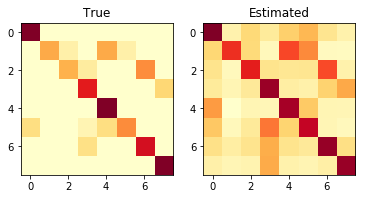

In [31]:
compare_conf_mats(conf_mats[:,:,2], weights[0][:,:,2])

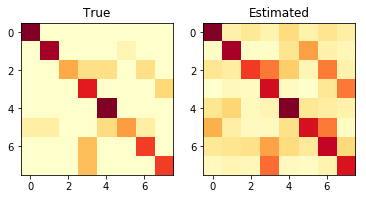

In [32]:
compare_conf_mats(conf_mats[:,:,9], weights[0][:,:,9])

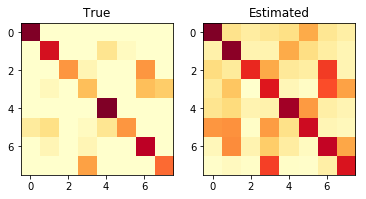

In [33]:
compare_conf_mats(conf_mats[:,:,20], weights[0][:,:,20])

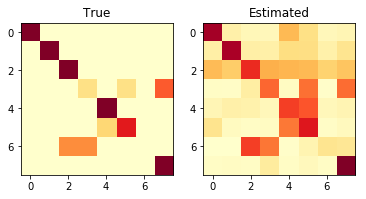

In [34]:
compare_conf_mats(conf_mats[:,:,23], weights[0][:,:,23])

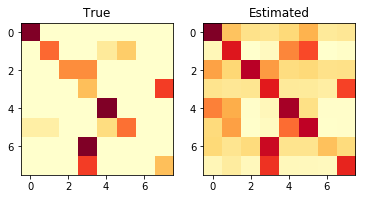

In [35]:
compare_conf_mats(conf_mats[:,:,30], weights[0][:,:,30])

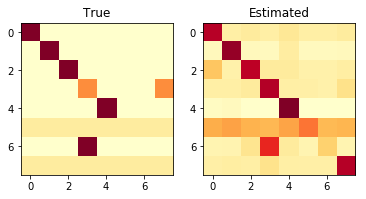

In [36]:
compare_conf_mats(conf_mats[:,:,36], weights[0][:,:,36])

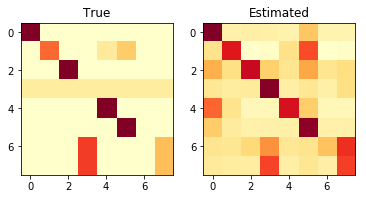

In [37]:
compare_conf_mats(conf_mats[:,:,39], weights[0][:,:,39])

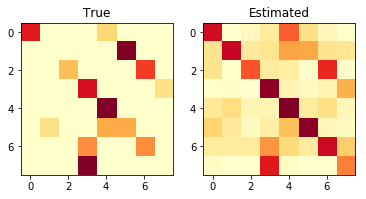

In [38]:
compare_conf_mats(conf_mats[:,:,45], weights[0][:,:,45])

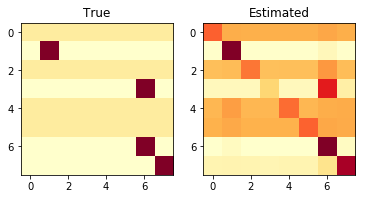

In [39]:
compare_conf_mats(conf_mats[:,:,56], weights[0][:,:,56])

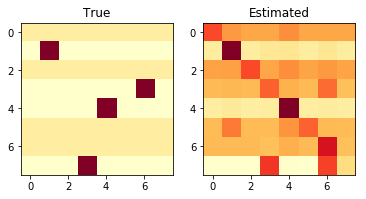

In [40]:
compare_conf_mats(conf_mats[:,:,58], weights[0][:,:,58])